In [1]:
from datasets import load_dataset
from utils import mp3_compress, opus_compress, encodec_compress
from utils import hf_audio_encode
from demucs.separate import Separator
import encodec
import numpy as np
import matplotlib.pyplot as plt
import torch

2023-10-24 17:19:27.495998: I tensorflow/core/util/port.cc:111] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-10-24 17:19:27.515055: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-10-24 17:19:27.515069: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-10-24 17:19:27.515086: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-10-24 17:19:27.519057: I tensorflow/core/platform/cpu_feature_g

In [2]:
device = "cuda"
encodec_model_48_6 = encodec.EncodecModel.encodec_model_48khz()
encodec_model_48_6.set_target_bandwidth(6)
encodec_model_48_6.to(device);

In [28]:
def mp3_compress_musdb(sample):
    audio = torch.tensor(sample['mixture']['array']).to(torch.float32)
    fs = sample['mixture']['sampling_rate']
    audio,bps = mp3_compress(audio,fs)
    sample['mixture'] = hf_audio_encode(audio,fs)
    sample['bps'] = bps
    return sample

def opus_compress_musdb(sample):
    audio = torch.tensor(sample['mixture']['array']).to(torch.float32)
    fs = sample['mixture']['sampling_rate']
    audio,bps = opus_compress(audio,fs)
    sample['mixture'] = hf_audio_encode(audio,fs)
    sample['bps'] = bps
    return sample

def encodec_48_6_compress_musdb(sample):
    audio = torch.tensor(sample['mixture']['array']).to(torch.float32)
    fs = sample['mixture']['sampling_rate']
    audio,bps = encodec_compress(audio,fs,encodec_model_48_6,device)
    sample['mixture'] = hf_audio_encode(audio,fs)
    sample['bps'] = bps
    return sample

In [29]:
audio_compression_methods = [
    mp3_compress_musdb,
    opus_compress_musdb,
    encodec_48_6_compress_musdb
]
models = []

In [30]:
musdb = load_dataset("danjacobellis/musdb",split='test')
musdb_mix = musdb.remove_columns(['drums', 'bass', 'other', 'vocals'])

In [32]:
musdb_compressed = []
for method in audio_compression_methods:
    musdb_compressed.append(musdb_mix.map(method))

In [63]:
orig = musdb[1]['mixture']['array']
mp3 = musdb_compressed[1][1]['mixture']['array']
opus = musdb_compressed[1][1]['mixture']['array']
ecdc = musdb_compressed[2][1]['mixture']['array']

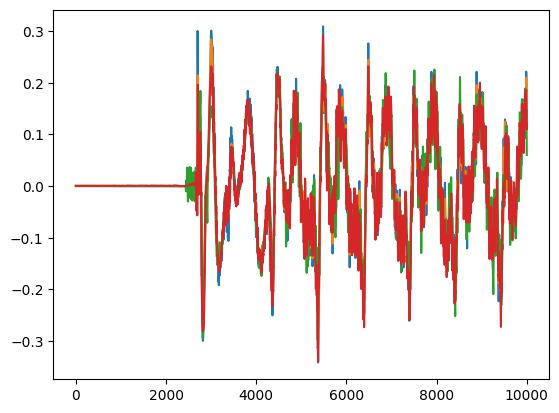

In [72]:
ind = 70000
L = 10000
plt.plot(orig[1][ind:ind+L])
plt.plot(mp3[1][ind:ind+L])
plt.plot(opus[1][ind:ind+L])
plt.plot(ecdc[1][ind:ind+L])

In [18]:
[cm[0]['mixture']['array'].shape for cm in musdb_compressed]

[(2, 9267840), (2, 10085077), (2, 9265664)]

In [ ]:
musdb_compressed[0][0]['mixture']['array'].shape

In [9]:
name = []
mixture = []
bps = []
for sample in musdb.remove_columns(['drums', 'bass', 'other', 'vocals']):
    sample = mp3_compress_musdb(sample)
    name.append(sample['name'])
    mixture.append(sample['mixture'])
    bps.append(sample['bps'])

formats: mp3 can't encode MPEG audio (layer I, II or III) to 16-bit
formats: mp3 can't encode MPEG audio (layer I, II or III) to 16-bit
formats: mp3 can't encode MPEG audio (layer I, II or III) to 16-bit
formats: mp3 can't encode MPEG audio (layer I, II or III) to 16-bit
formats: mp3 can't encode MPEG audio (layer I, II or III) to 16-bit
formats: mp3 can't encode MPEG audio (layer I, II or III) to 16-bit
formats: mp3 can't encode MPEG audio (layer I, II or III) to 16-bit
formats: mp3 can't encode MPEG audio (layer I, II or III) to 16-bit
formats: mp3 can't encode MPEG audio (layer I, II or III) to 16-bit
formats: mp3 can't encode MPEG audio (layer I, II or III) to 16-bit
formats: mp3 can't encode MPEG audio (layer I, II or III) to 16-bit
formats: mp3 can't encode MPEG audio (layer I, II or III) to 16-bit
formats: mp3 can't encode MPEG audio (layer I, II or III) to 16-bit
formats: mp3 can't encode MPEG audio (layer I, II or III) to 16-bit
formats: mp3 can't encode MPEG audio (layer I, I

In [ ]:
len(mixture[1]['bytes'])

In [92]:
features=datasets.Features({
    "name": datasets.Value("string"),
    "mixture": datasets.Audio(sampling_rate=fs, mono=False, decode=False),
    "bps": datasets.Value("float")
})

In [94]:
musdb_mp3 = datasets.Dataset.from_dict(
    {
        'name': name,
        'mixture': mixture,
        'bps': bps
    },
    features=features
)

In [102]:
len(musdb_mp3[0]['mixture']['bytes'])

58

In [97]:
musdb_mp3.push_to_hub("danjacobellis/musdb_mp3",split='test')

Map:   0%|          | 0/15 [00:00<?, ? examples/s]

Pushing dataset shards to the dataset hub:   0%|          | 0/1 [00:00<?, ?it/s]

Creating parquet from Arrow format:   0%|          | 0/1 [00:00<?, ?ba/s]

In [1]:

# import torchaudio
# import torch
# import matplotlib.pyplot as plt
# import museval
# import numpy as np

In [9]:
separator = Separator()

In [45]:
mp3 = musdb[1]
mp3 = mp3.remove_columns(['drums','bass','other','vocals'])
# mp3.remove_columns('bass')
# mp3.remove_columns('other')
# mp3.remove_columns('vocals')
# mp3.remove_columns('bps')

In [47]:
mp3.push_to_hub("danjacobellis/musdb_mp3",split="test")

Map:   0%|          | 0/15 [00:00<?, ? examples/s]

Pushing dataset shards to the dataset hub:   0%|          | 0/1 [00:00<?, ?it/s]

Creating parquet from Arrow format:   0%|          | 0/1 [00:00<?, ?ba/s]

In [50]:
musdb[3]['mixture']

LibsndfileError: Error opening <_io.BytesIO object at 0x7fec62495350>: Too many channels specified.

In [36]:
mp3.remove_columns('drums')

Dataset({
    features: ['name', 'mixture', 'bass', 'other', 'vocals', 'bps'],
    num_rows: 15
})

In [31]:
musdb[1].drop_index('drums')

KeyError: 'drums'

In [8]:

origin, separated = separator.separate_audio_file("mixture.mp3")

Using first example from
https://ai.honu.io/papers/htdemucs/index.html

In [3]:
files = [
    "mixture.mp3",
    "drums.mp3",
    "bass.mp3",
    "other.mp3",
    "vocals.mp3"
]
reference = [
    torchaudio.load(file)[0].unsqueeze(0)
    for file in files
]
fs = torchaudio.load(files[0])[1]

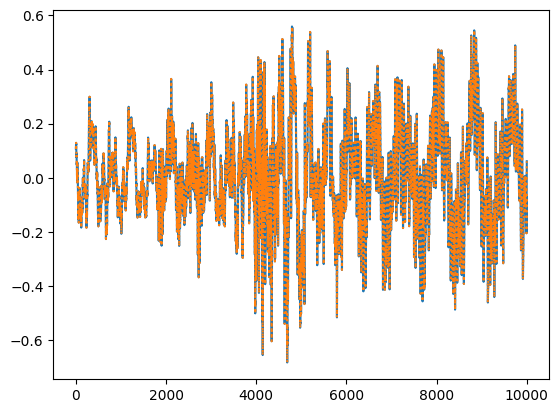

In [4]:
plt.plot(reference[0][0].mean(dim=0)[0:10000]);
plt.plot(origin.mean(dim=0)[0:10000],':');

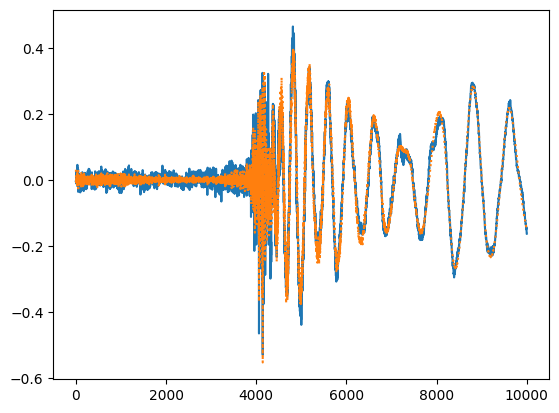

In [5]:
plt.plot(reference[1][0].mean(dim=0)[0:10000]);
plt.plot(separated['drums'].mean(dim=0)[0:10000],':');

In [6]:
reference_sources = torch.cat(reference[1:]).permute(0,2,1)

In [7]:
reference_sources.shape

torch.Size([4, 882000, 2])

In [8]:
estimated_sources = [
    separated['drums'],
    separated['bass'],
    separated['other'],
    separated['vocals']
]
estimated_sources = torch.cat([
    source.unsqueeze(0) 
    for source in estimated_sources
]).permute(0,2,1)

In [9]:
estimated_sources.shape

torch.Size([4, 882000, 2])

In [10]:
sdr, isr, sir, sar, perm = museval.metrics.bss_eval(
    reference_sources,
    estimated_sources,
    window=2 * 44100,
    hop=1.5 * 44100,
    compute_permutation=False,
    filters_len=512,
    framewise_filters=False,
    bsseval_sources_version=False,
)

In [11]:
np.mean(sdr)

6.627512416668513